---

# **INDICIUM**

## Desafio de Ciência de Dados para o programa <b>LightHouse</b><br>

Autor: Jorge Henrique Peripolli <br>
Contato: jorge.peripolli@gmail.com

A execução do desafio foi dividida em 4 partes:
- 1. Preparaçao dos Dados
- 2. EDA
- 3. Respostas as perguntas do desafio
- 4. Modelo de previsão

Fico a disposição em caso de dúvidas ou sugestões

---

# CARREGAR BILIOTECAS

In [166]:
#MANIPULAÇÃO DE DADOS
import pandas as pd
import numpy as np
from collections import Counter

#VISUALIZAÇÃO DE DADOS
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#MACHINE LEARNING
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR

#OUTROS
import warnings
warnings.filterwarnings("ignore")
import pickle



# FUNÇÕES

In [167]:
# Gráfico de barras
def função_gráfico_barra(x_dados, y_dados, título):

    plt.figure(figsize=(20, 6))
    sns.barplot(x=x_dados, y=y_dados, palette='viridis')

    # Adicionando título e rótulos aos eixos
    plt.title(título)
    plt.xlabel(x_dados.name)
    plt.ylabel(y_dados.name)

    # Mostrando o gráfico
    plt.show()


def função_testa_modelo(modelo_regressão_teste,parâmetros,resultados_modelos):
    
    # Definir o modelo a ser criado
    modelo_regressão = modelo_regressão_teste

    # Criar a pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessamento),
        ('modelo', modelo_regressão)
    ])

    # Aplicar o GridSearch
    grid_search = GridSearchCV(
        pipeline,  # Executa a pipeline com o preprocessamento e o modelo de regressão
        parâmetros,  # Carrega os parâmetros a serem testados pelo modelo
        cv=5,  # Faz um cross-validation 5 vezes
        scoring= 'neg_mean_absolute_error'
    )

    # Treinar o modelo
    grid_search.fit(X, y)

    #Exibe os dados
    print(f"\nModelo testado: {modelo_regressão}\n")
    print("Melhores parâmetros encontrados:")
    print(grid_search.best_params_)
    print("\nMelhor score de MAE encontrado:")
    print(round(grid_search.best_score_,4))

    #Carrega o resultado do modelo para a variável resultados_modelos
    resumo_modelo = {
        'Modelo': modelo_regressão,
        'Parâmetros': grid_search.best_params_,
        'MAE': round(grid_search.best_score_, 4)
        }

    #Faz o append   
    resultados_modelos.append(resumo_modelo)
    print("")

    return(resultados_modelos)
    
def geração_cloud_word(overview_concatenado):

    #Geração de CloudWord
    #Stopwords são palavras, pronomes ou artigos que podem ser ignorados na hora de processar um texto.
    #A própria biblioteca WordCloud já traz esse recurso.
    stopwords = set(STOPWORDS)

    wc = WordCloud(background_color="white",
                  max_words=2000,
                  stopwords=stopwords, contour_width=3, contour_color='steelblue')

    # generate word cloud
    wc.generate(overview_concatenado)

    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
    plt.show()

def função_palavras_frequentes(overview_concatenado):
    #Define as stopwords
    wordcloud = WordCloud(stopwords=STOPWORDS)
    
    palavras_nuvem = wordcloud.process_text(overview_concatenado)
    palavras_frequentes_por_gênero = Counter(palavras_nuvem)
    palavras_frequentes_por_gênero = palavras_frequentes_por_gênero.most_common(10)
    palavras_frequentes_por_gênero  = pd.DataFrame(palavras_frequentes_por_gênero)

    #Renomeia as colunas
    palavras_frequentes_por_gênero.columns =['Palavra','Frequência']

    #Exibe as palavras mais frequentes daquele gênero
    print(palavras_frequentes_por_gênero)

    return (palavras_frequentes_por_gênero)
    

# 1. PREPARAÇÃO DOS DADOS

DICIONÁRIO DE DADOS

Esse é o dicionário de dados disponibilizado para o desafio:

<li>Series_Title – Nome do filme</li>
<li>Released_Year - Ano de lançamento</li>
<li>Certificate - Classificação etária</li>
<li>Runtime – Tempo de duração</li>
<li>Genre - Gênero</li>
<li>IMDB_Rating - Nota do IMDB</li>
<li>Overview - Overview do filme</li>
<li>Meta_score - Média ponderada de todas as críticas </li>
<li>Director – Diretor</li>
<li>Star1 - Ator/atriz #1</li>
<li>Star2 - Ator/atriz #2</li>
<li>Star3 - Ator/atriz #3</li>
<li>Star4 - Ator/atriz #4</li>
<li>No_of_Votes - Número de votos</li>
<li>Gross - Faturamento</li>


## 1.1 Carregar os dados

In [168]:
#Lê o csv
df = pd.read_csv('desafio_indicium_imdb.csv')

#Converte para df
df = pd.DataFrame(df)

print(df.head())

   Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
1  W

## 1.2 Shape do DataFrame

Verifica o shape(dimensão) do DataFrame

In [169]:
shape = df.shape

print(f'O dataframe possui {shape[0]} linhas e {shape[1]} colunas')

O dataframe possui 999 linhas e 16 colunas


## 1.3 Verificaçao de linhas repetidas

In [170]:
duplicados = df.duplicated().sum()

print(f"O dataframe possui {duplicados} linha(s) duplicada(s)")


O dataframe possui 0 linha(s) duplicada(s)


## 1.4 - Ajustando o DataFrame

In [171]:
#Verifica o tipo de dado de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


### 1.4.1 - Ajustando o DataFrame: remoção de coluna

A coluna 'Unnamed: 0' não traz nenhum valor e pode ser removida do dataframe

In [172]:
#Remove a coluna 
df = df.drop(columns=['Unnamed: 0'])

### 1.4.2 - Conversão das variáveis numéricas de string para numérico


In [173]:
#Converte a coluna IMDB_Rating para float
df['IMDB_Rating'] = df['IMDB_Rating'].astype(float)

#Converte a coluna Meta_score para float
df['Meta_score'] = df['Meta_score'].astype(float)

#Converte a coluna No_of_Vote para float
df['No_of_Votes'] = df['No_of_Votes'].astype(float)

#Verifica se a conversão foi feita para o formato Float
print("No_of_Votes dtype:", df['No_of_Votes'].dtype)
print("Meta_score dtype:", df['Meta_score'].dtype)
print("IMDB_Rating dtype:", df['IMDB_Rating'].dtype)

No_of_Votes dtype: float64
Meta_score dtype: float64
IMDB_Rating dtype: float64


#### 1.4.2.1 - Conversão das variáveis numéricas de string para numérico: Gross

A coluna Gross (faturamento) está em formato de string e tem os valores apresentados com vírgulas.
A seguintes etapas serão feitas:<br>
    <br>1) Remoção da vírgula;<br>
    <br>2) Substituição dos valores Nan por np.nan. Isso permite que os valores nulos não atrapalhem a conversão<br>
    <br>3) Conversão para float<br>


In [174]:
#Remove a vírgula da coluna Gross
df['Gross'] = df['Gross'].str.replace(',','')

#Converte a coluna Gross para float
df['Gross'] = df['Gross'].astype(float)

#### 1.4.2.2 - Conversão das variáveis numéricas de string para numérico: Released_Year

Ao tentar converter a coluna 'Released_Year' ocorreu um erro informando que não seria possível converter a variável 'PG'.

Verificou-se que se tratava de um único valor e foi optado por subtituir manualmente o valor 'PG' pelo ano do lançamento.
Ano do lançamento do filme consultado em https://www.imdb.com/title/tt0112384/

Em seguida a coluna é convertida para valores inteiros

In [175]:
#Verifica a ocorrência única dos anos de lançamento

#Ocorrências únicas para a coluna 'Released_Year'
print(f"Ocorrências únicas: \n{df['Released_Year'].sort_values().unique()}")

#Identifica a linha com a variável 'PG'
linha_PG = df[df['Released_Year']=='PG']

#Conta o total de corrências da variável 'PG'
print('\n')
print(f"Há {len(linha_PG)} ocorrência(s) da string 'PG'")

#Mostra a filme da ocorrência da variável 'PG'
print('\n')
print(f"O filme com a ocorrência de 'PG' é o {linha_PG.iloc[0][0]}")

#Insere o ano do filme
df['Released_Year'].replace('PG',1995,inplace=True)

#Converte o ano para integral
df['Released_Year'] = df['Released_Year'].astype(int)

Ocorrências únicas: 
['1920' '1921' '1922' '1924' '1925' '1926' '1927' '1928' '1930' '1931'
 '1932' '1933' '1934' '1935' '1936' '1937' '1938' '1939' '1940' '1941'
 '1942' '1943' '1944' '1945' '1946' '1947' '1948' '1949' '1950' '1951'
 '1952' '1953' '1954' '1955' '1956' '1957' '1958' '1959' '1960' '1961'
 '1962' '1963' '1964' '1965' '1966' '1967' '1968' '1969' '1970' '1971'
 '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979' '1980' '1981'
 '1982' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990' '1991'
 '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001'
 '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' 'PG']


Há 1 ocorrência(s) da string 'PG'


O filme com a ocorrência de 'PG' é o Apollo 13


###

### 1.4.2.3 - Conversão das variáveis numéricas de string para numérico: Runtime

A coluna 'Runtime' (duração do filme) está em formato de string (Ex.: '175 min').
Para deixar a duração do filme em um número inteiro será preciso remover o elemento de texto e transformar o restante em número

In [176]:
#Identificafica e remove o texto ' min' e converte para um número inteiro
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)


## 1.4.3 - Verifica os valores nulos

Verifica a quantidade de valores nulos em cada coluna

In [177]:
print(df.isna().sum())

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64


## 1.4.4 - Describe


In [178]:
round(df.describe(),1)

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.0,999.0,999.0,842.0,999.0,830.0
mean,1991.2,122.9,7.9,78.0,271621.4,68082574.1
std,23.3,28.1,0.3,12.4,320912.6,109807553.4
min,1920.0,45.0,7.6,28.0,25088.0,1305.0
25%,1976.0,103.0,7.7,70.0,55471.5,3245338.5
50%,1999.0,119.0,7.9,79.0,138356.0,23457439.5
75%,2009.0,137.0,8.1,87.0,373167.5,80876340.2
max,2020.0,321.0,9.2,100.0,2303232.0,936662225.0


In [179]:
#Agora que o DF foi tratado vamos renomeá-lo para 'imdb'
imdb = df.copy()

# **2 - EDA**

A EDA (exploratory data analysis) terá como foco orientar a melhor escolha da PProductions para o seu próximo filme.

## 2.1 - Classificação Etária (Certificate)



In [180]:
#Tipos de classificações etárias
tipos_certificate = imdb['Certificate'].sort_values().unique()
print(f"Os tipos de Classificação Etária são: \n {tipos_certificate}")

Os tipos de Classificação Etária são: 
 ['16' 'A' 'Approved' 'G' 'GP' 'PG' 'PG-13' 'Passed' 'R' 'TV-14' 'TV-MA'
 'TV-PG' 'U' 'U/A' 'UA' 'Unrated' nan]


In [181]:
#Como há valores nan eles serão substutuídos por 'Unrated'

imdb['Certificate'].fillna('Unrated',inplace=True)

Como algumas das abreviações das classificaçãos etárias não são intuitivas, foi consultado a relação de Certificates (classificações etárias) do 
<a href="https://help.imdb.com/article/contribution/titles/certificates/GU757M8ZJ9ZPXB39?ref_=helpart_nav_27#attributes" target="_blank">próprio IMB.</a>
A busca da relação do IMDB também não é intuitiva uma vez que no dataset há mistura de classificações de diferentes países. Chegou-se a seguinte definição:


<li>16: Maiores de 16 anos</li>
<li>A: Adult</li>
<li>Approved: Pré regulação de 1968. O filme era aprovado ou não</li>
<li>G: Para todas as audiências</li>
<li>PG: Menores de 10 anos acompanhado dos pais</li>
<li>PG-13: Menores de 13 anos acompanhado dos pais</li>
<li>R: Menores de 17 só acompanhado dos pais</li>
<li>TV-14: Somente para maiores de 14 anos</li>
<li>TV-MA: Somente para adultos</li>
<li>TV-PG: Permitido para Crianças</li>
<li>U: Universal. Liberado para todas as idades</li>
<li>U/A, UA: Não recomendado para menores de 12 anos</li>

Como U/A, UA tem a mesma classificação eles serão unidos


In [182]:
#Unindo U/A e UA
imdb['Certificate'] = imdb['Certificate'].replace('U/A', 'UA')

print(imdb['Certificate'].unique())

['A' 'UA' 'U' 'PG-13' 'R' 'Unrated' 'PG' 'G' 'Passed' 'TV-14' '16' 'TV-MA'
 'GP' 'Approved' 'TV-PG']


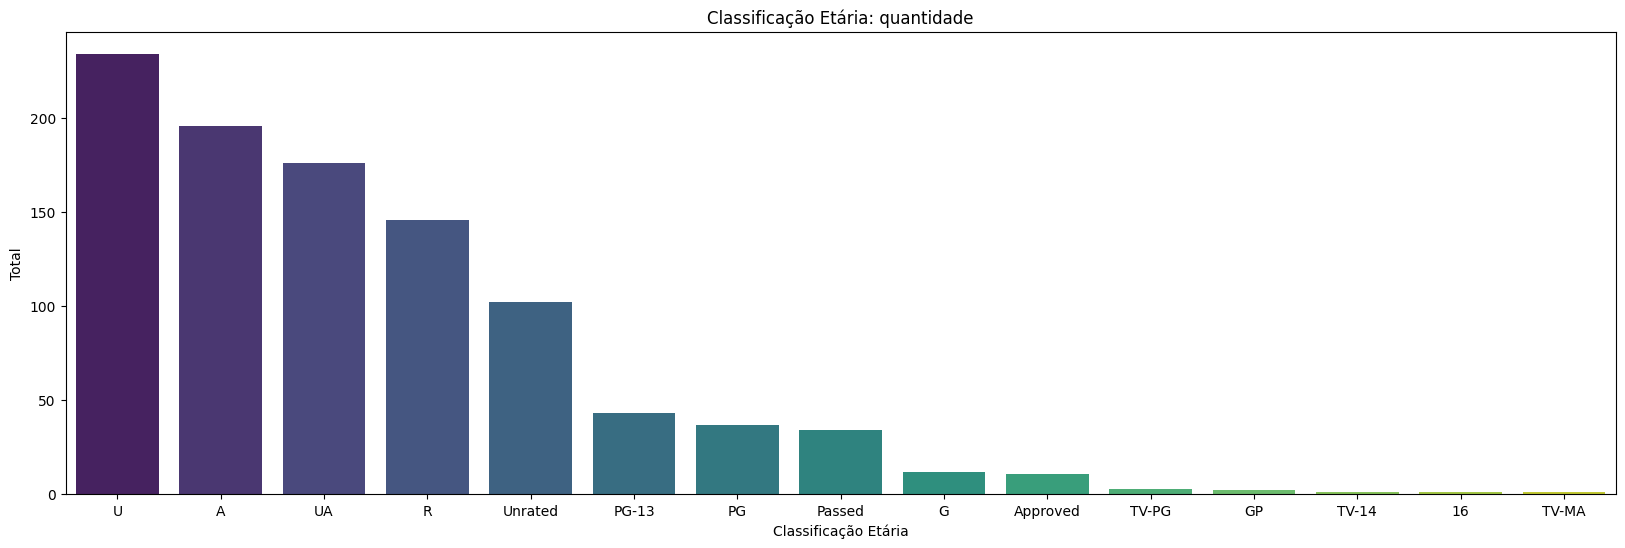

In [183]:
## 2.1.1 - Classificação Etária: quantidade

#Copia as colunas desejadas
classificação_etária_quantidade = imdb['Certificate'].value_counts().reset_index()

#Renomeia as colunas
classificação_etária_quantidade.columns = ['Classificação Etária','Total']

#Calcula a %
classificação_etária_quantidade['%'] = classificação_etária_quantidade['Total'].apply(lambda x: (x/classificação_etária_quantidade['Total'].sum())*100 )

#Arrendonda a %
classificação_etária_quantidade['%'] = round(classificação_etária_quantidade['%'],2)

#Faz o gráfico
função_gráfico_barra(classificação_etária_quantidade['Classificação Etária'],classificação_etária_quantidade['Total'],'Classificação Etária: quantidade')


### 2.1.2 - Classificação Etária: faturamento

   Classificação Etária  Faturamento médio (em milhões de US$)
0                    UA                                 130.50
1                     U                                  87.25
2                     A                                  64.09
3                     G                                  49.60
4                 PG-13                                  36.95
5                     R                                  25.79
6                    PG                                  17.89
7              Approved                                   6.95
8                Passed                                   5.44
9               Unrated                                   3.58
10                   GP                                   0.71
11                TV-PG                                   0.11
12                   16                                    NaN
13                TV-14                                    NaN
14                TV-MA                                

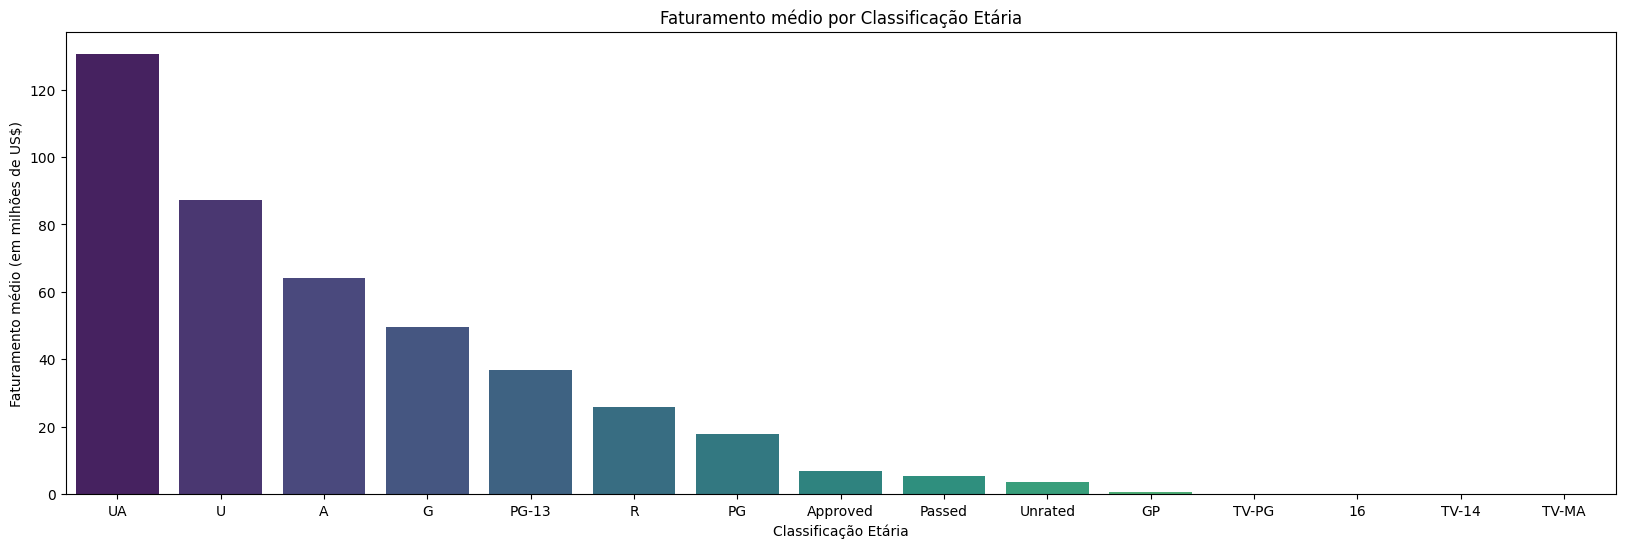

In [184]:
#Seleciona as colunas desejadas
classificação_etária_faturamento_médio = imdb[['Certificate','Gross']].copy()

#Agrupa as idades
classificação_etária_faturamento_médio = imdb.groupby('Certificate')['Gross'].mean().sort_values(ascending=False).reset_index()

#Converte para milhões de dólares para melhor visualização
classificação_etária_faturamento_médio['Gross'] = classificação_etária_faturamento_médio['Gross']/1000000

#Arredonda o faturamento
classificação_etária_faturamento_médio['Gross'] = round(classificação_etária_faturamento_médio['Gross'],2)

#Renomeia as colunas
classificação_etária_faturamento_médio.columns = ['Classificação Etária','Faturamento médio (em milhões de US$)']

#Exbição dos dados
print(classificação_etária_faturamento_médio)

#Faz o gráfico de barra
função_gráfico_barra(classificação_etária_faturamento_médio['Classificação Etária'],classificação_etária_faturamento_médio['Faturamento médio (em milhões de US$)'],'Faturamento médio por Classificação Etária')




### 2.1.2 - Classificação Etária: análise

Os filmes de classificação U (Universal) compreendem quase um quarto (23,42%) dos filmes registrados no banco de dados, seguido de filmes A (Adulto) com 19,62% e UA (Não recomendado para menores de 12 anos).

A classificação etária com melhor faturamento é a do tipo UA(não recomendado para menores de 12 anos) com uma média de 131 milhões de dólares. Esse valor é quase 50% maior que o segundo colocado U (universal).

Uma hipótese para explicar a diferença entre classificação e faturamento é que os filmes U (os mais frequentes e abrangentes em público) enfrentam uma competição maior entre si, o que leva a um faturamento menor.

Um filme UA tende a apresentar um retorno maior frente as outras classificações, apesar de ter um público mais restringido.

## 2.2 - Lançamentos por ano

Ano de Lançamento

     Ano  Total
90  1920      1
95  1921      1
97  1922      1
93  1924      1
85  1925      2
..   ...    ...
4   2016     28
14  2017     22
18  2018     19
10  2019     23
58  2020      6

[99 rows x 2 columns]


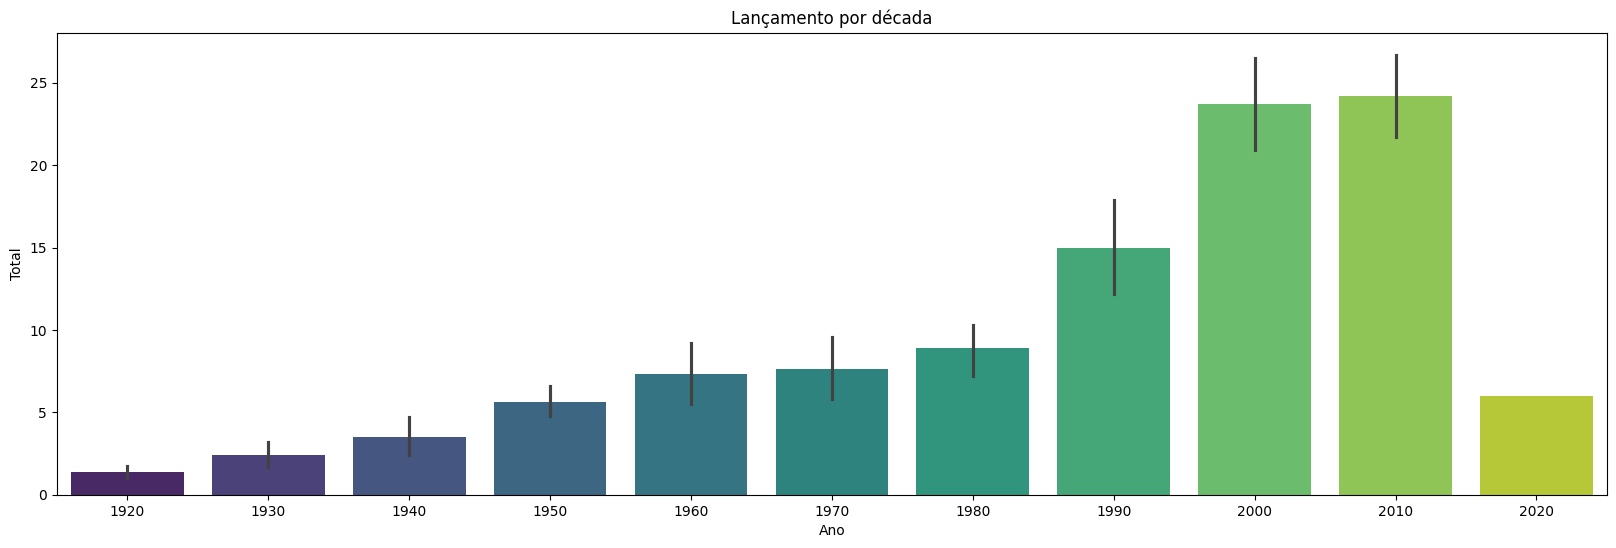

In [185]:
#Faz a cópia dos dados
lançamento_ano = imdb['Released_Year'].copy()

#Faz a contagem de ocorrências
lançamento_ano = lançamento_ano.value_counts().reset_index()

#Renomeia as colunas
lançamento_ano.columns = ['Ano','Total']

#Ordena pelo ano de lançamento
lançamento_ano = lançamento_ano.sort_values(by='Ano')

#Exibe os dados
print('Ano de Lançamento\n')
print(lançamento_ano)

#Para facilitar a visualização optou-se por agrupar os lançamentos por décadas
lançamento_ano['Ano'] = (lançamento_ano['Ano'] // 10) *10

#Faz o gráfico de barra
função_gráfico_barra(lançamento_ano['Ano'],lançamento_ano['Total'],'Lançamento por década')

### 2.2.1 - Lançamentos por ano: análise

Pode-se observar que nas décadas de 1960, 1970 e 1980 foi praticamente estável.
Algumas hipóteses que explicam o crescimentos de lançamentos das últimas décadas são:
<li>Maior demanda de filmes em razão da popularização do VHS e videolocadora nos anos 1990</li>
<li>A demanda continuou crescendo nos anos 2000 com a introdução do DVD, que permitiu uma melhor experiência de qualidade de imagem em casa.</li>
<li>Nos anos 2010 há a popularização das SmartTVs e dos serviços de streaming. Nesse período os próprios serviços de streaming passaram a criar filmes próprios.
<li>A aparente queda nos anos 2020 se dá pelo fato da década ainda estar em andamento.

## 2.3 - Gênero

### 2.3.1 - Gênero mais popular

Popularidade por gênero

       Gênero  Total
0       Drama    723
1      Comedy    233
2       Crime    209
3   Adventure    196
4      Action    189
5    Thriller    137
6     Romance    125
7   Biography    109
8     Mystery     99
9   Animation     82
10     Sci-Fi     67
11    Fantasy     66
12     Family     56
13    History     56
14        War     51
15      Music     35
16     Horror     32
17    Western     20
18  Film-Noir     19
19      Sport     19
20    Musical     17


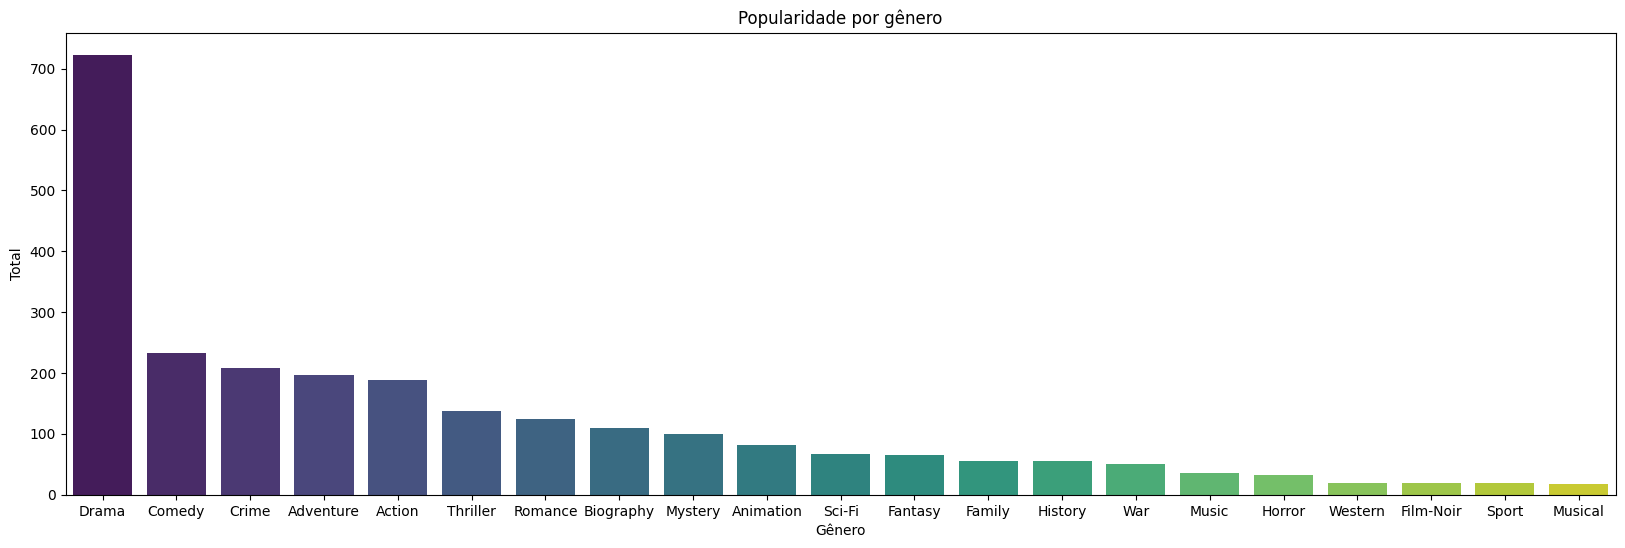

In [186]:
#Copia os dados
gênero = imdb['Genre'].copy()

#Faz a separaçao por gênero
gênero = gênero.str.split(', ')
gênero = gênero.explode('Genre').reset_index(drop=True)

#Faz a contagem
gênero = gênero.value_counts().reset_index()

#Renomeia as colunas
gênero.columns = ['Gênero','Total']

#Exibe os dados
print("Popularidade por gênero\n")
print(gênero)

função_gráfico_barra(gênero['Gênero'],gênero['Total'],'Popularidade por gênero')

### 2.3.2 - Faturamento por Gênero

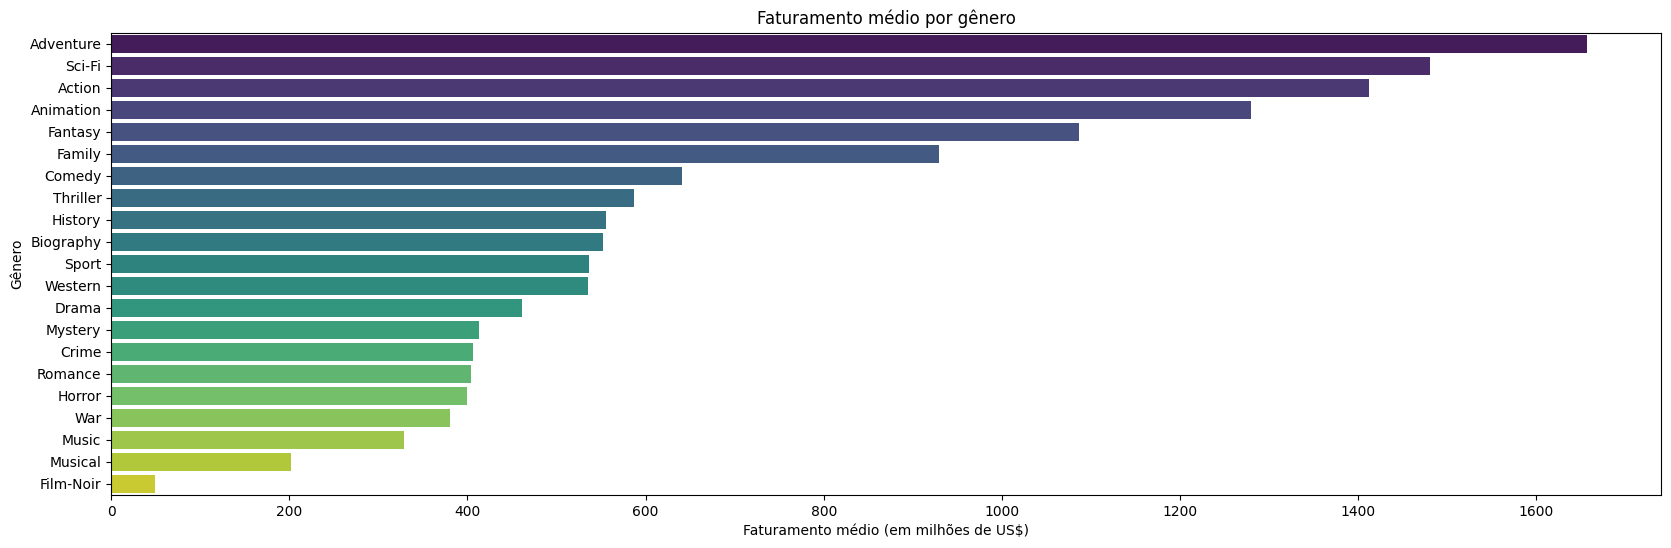

In [187]:
#Copia os dados desejados
gênero_faturamento = imdb[['Genre','Gross']].copy()

#Faz a separação por gênero
gênero_faturamento['Genre'] = gênero_faturamento['Genre'].str.split(', ') 
gênero_faturamento = gênero_faturamento.explode('Genre').reset_index(drop=True)

#Calcula a média de faturamento por gênero
gênero_faturamento = gênero_faturamento.groupby('Genre').mean().reset_index()

#Renomeia as colunas
gênero_faturamento.columns = ['Gênero','Faturamento médio (em milhões de US$)']

#Converte o faturamento para milhões
gênero_faturamento['Faturamento médio (em milhões de US$)'] = (gênero_faturamento['Faturamento médio (em milhões de US$)'] / 100000)

#Arrendondamento
gênero_faturamento['Faturamento médio (em milhões de US$)'] = round(gênero_faturamento['Faturamento médio (em milhões de US$)'],2)

#Ordena
gênero_faturamento.sort_values(by='Faturamento médio (em milhões de US$)', ascending = False, inplace=True)

#Chama a função de fazer gráfico de barra
função_gráfico_barra(gênero_faturamento['Faturamento médio (em milhões de US$)'],gênero_faturamento['Gênero'],'Faturamento médio por gênero')

### 2.3.3 - Gênero e Avalição IMDB

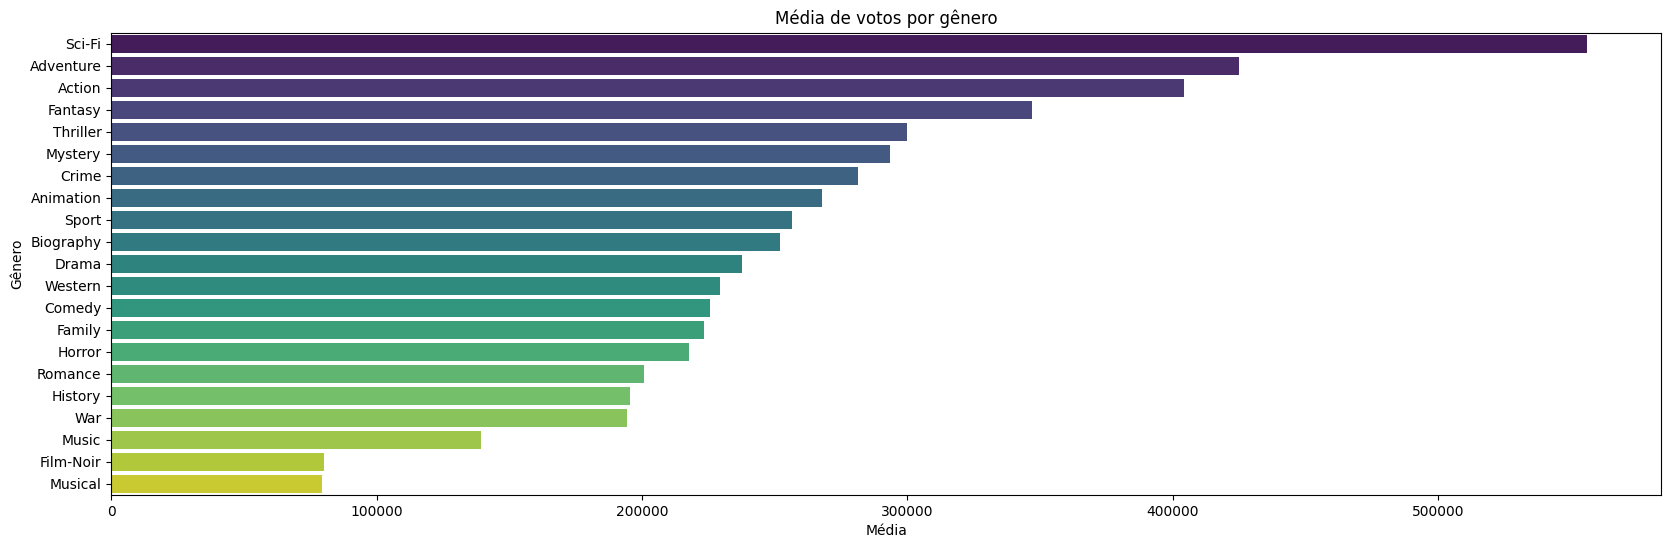

In [188]:
#Copia os dados
gênero_avaliação = imdb[['Genre','No_of_Votes']].copy()

gênero_avaliação['Genre'] = gênero_avaliação['Genre'].str.split(', ') 
gênero_avaliação = gênero_avaliação.explode('Genre').reset_index(drop=True)

#Calcula a média
gênero_avaliação = gênero_avaliação.groupby(by='Genre').agg({
    'No_of_Votes': ['mean','sum']
}).reset_index()

#Renomeia as colunas
gênero_avaliação.columns = ['Gênero','Média','Total de Votos']

#Arredonda os valores
gênero_avaliação = round(gênero_avaliação)

#Ordena os valores pela média
gênero_avaliação = gênero_avaliação.sort_values(by='Média', ascending = False)

#Chama a função de fazer gráfico
função_gráfico_barra(gênero_avaliação['Média'],gênero_avaliação['Gênero'],'Média de votos por gênero')



### 2.3.4 - Gênero: análise

Com base nos dados sobre os gêneros de filmes pode-se fazer as seguintes afirmações:

- Os maiores gêneros de filme mais populares são respectivamente: <b>Drama, Comédia e Crime</b>.
    - Uma hipótese para essa prevalência desses gêneros pode ser em razão dos custos mais baixos desse tipo de filme

- Os filmes com maior <b> FATURAMENTO MÉDIO</b> são os de <b>Aventura, Sci-fi e Ação</b>. Optou-se pela média de faturamento e não o total porque um único filme de sucesso excepcional seria capaz de ocultar o desempenho geral do gênero.

- Os filmes com maior média de votação são Sci-fi, Aventura e Ação. Isso sugere que esses gêneros geram mais engajamento entre os espectadores.


## 2.4 - Atores mais populares


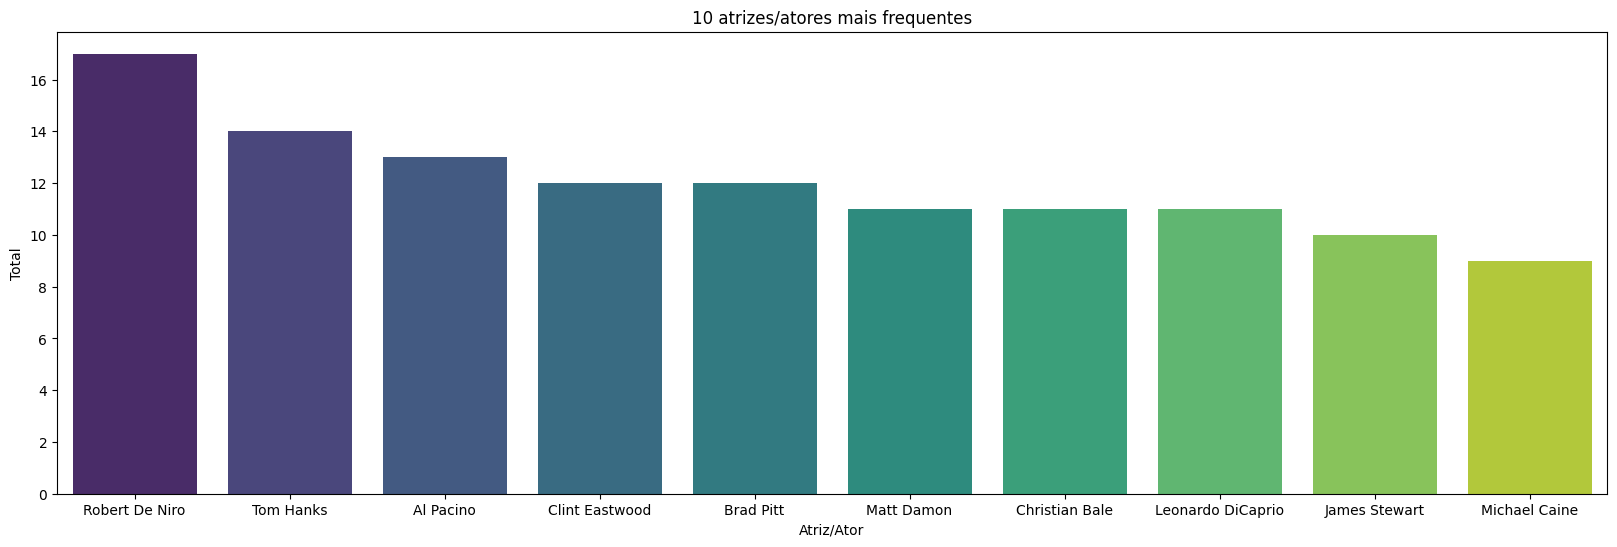

In [189]:
atores = imdb[['Star1','Star2','Star3','Star4']].copy()

#Cria uma variável vazia
atores_total_filmes = []

#Concatena as 4 colunas de atrizes/atores
atores_total_filmes = pd.concat([atores[col] for col in atores], ignore_index=True)

#Converte para dataframe
atores_total_filmes = pd.DataFrame(atores_total_filmes)

#Renomeia as colunas
atores_total_filmes.columns = ['Atriz/Ator']

#Agrupa as atrizes/atores mais frequentes
atores_total_filmes = atores_total_filmes.groupby('Atriz/Ator').value_counts().reset_index(name='Total')

#atores_total_filmes = atores_total_filmes['Atriz/Ator'].value_counts().reset_index(name='Total')

#Ordena por aparições em filmes
atores_total_filmes = atores_total_filmes.sort_values(by='Total',ascending=False)

#Chama função que faz o gráfico
função_gráfico_barra(atores_total_filmes['Atriz/Ator'].head(10), atores_total_filmes['Total'].head(10),'10 atrizes/atores mais frequentes')


## 2.5 Diretor(a)

### 2.5.1 - Diretor(a) com mais faturamento médio

         Diretor(a)  Faturamento Médio (em milhões de US$)
30    Anthony Russo                                 551.26
130  Gareth Edwards                                 532.18
168     J.J. Abrams                                 474.39
228     Josh Cooley                                 434.04
369    Roger Allers                                 422.78
431      Tim Miller                                 363.07
176      James Gunn                                 361.49
173   James Cameron                                 349.65
57     Byron Howard                                 341.27
93      David Yates                                 326.32


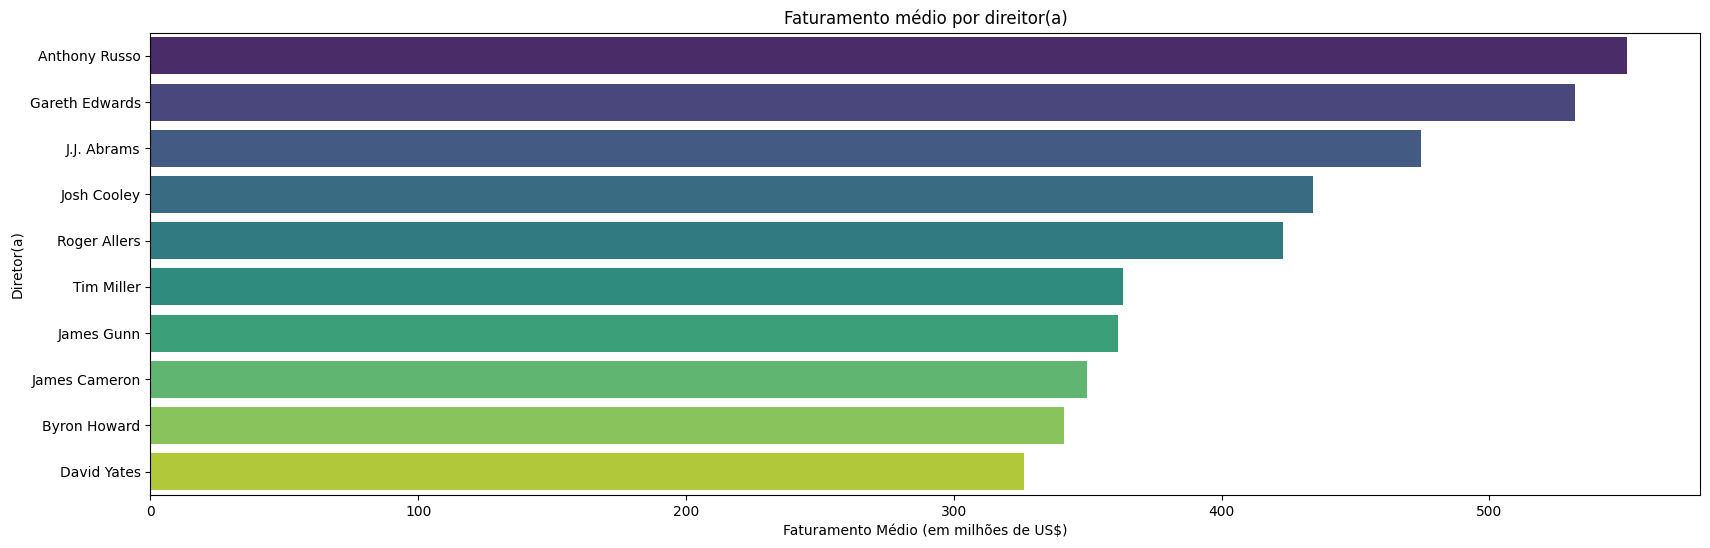

In [190]:
diretor_faturamento = imdb[['Director','Gross']].copy()

diretor_faturamento.dropna(inplace=True)

# Agrupa
diretor_faturamento = diretor_faturamento.groupby(by='Director').mean().reset_index()

# Renomeia as colunas
diretor_faturamento.columns = ['Diretor(a)', 'Faturamento Médio (em milhões de US$)']

# Converte para milhões de $
diretor_faturamento['Faturamento Médio (em milhões de US$)'] = round((diretor_faturamento['Faturamento Médio (em milhões de US$)'] / 1000000), 2)

# Ordena por faturamento médio
diretor_faturamento = diretor_faturamento.sort_values(by='Faturamento Médio (em milhões de US$)', ascending=False)

#Mostra os dados
print(diretor_faturamento.head(10))

#Chama a função que faz o gráfico
função_gráfico_barra(diretor_faturamento['Faturamento Médio (em milhões de US$)'].head(10),diretor_faturamento['Diretor(a)'].head(10),'Faturamento médio por direitor(a)')

### 2.5.2 Diretor(a) melhor avaliado (IMDB)

In [191]:
diretor_avaliação_imdb = imdb[['Director', 'IMDB_Rating']].copy()

diretor_avaliação_imdb.dropna(inplace=True)

# Agrupa
diretor_avaliação_imdb = diretor_avaliação_imdb.groupby(by='Director').mean().reset_index()

# Renomeia as colunas
diretor_avaliação_imdb.columns = ['Diretor(a)', 'Avaliação Média (IMDB)']

#Arredonda
diretor_avaliação_imdb['Avaliação Média (IMDB)'] = round(diretor_avaliação_imdb['Avaliação Média (IMDB)'], 2)

# Ordena por faturamento médio
diretor_avaliação_imdb = diretor_avaliação_imdb.sort_values(by='Avaliação Média (IMDB)', ascending=False)

#Mostra os dados
print(diretor_avaliação_imdb.head(10))

             Diretor(a)  Avaliação Média (IMDB)
191      Irvin Kershner                     8.7
284      Lana Wachowski                     8.7
158        George Lucas                     8.6
427     Roberto Benigni                     8.6
141      Frank Darabont                     8.6
316    Masaki Kobayashi                     8.6
492         Thomas Kail                     8.6
472       Sudha Kongara                     8.6
135  Fernando Meirelles                     8.6
428        Roger Allers                     8.5


### 2.5.3 Diretor(a) melhor avaliado (Meta_score)

In [192]:
diretor_avaliação_metascore = imdb[['Director', 'Meta_score']].copy()

diretor_avaliação_metascore.dropna(inplace=True)

# Agrupa
diretor_avaliação_metascore = diretor_avaliação_metascore.groupby(by='Director').mean().reset_index()

# Renomeia as colunas
diretor_avaliação_metascore.columns = ['Diretor(a)', 'Avaliação Média (Metascore)']

# Arredonda
diretor_avaliação_metascore['Avaliação Média (Metascore)'] = round(diretor_avaliação_metascore['Avaliação Média (Metascore)'], 2)

# Ordena por avaliação média de Metascore
diretor_avaliação_metascore = diretor_avaliação_metascore.sort_values(by='Avaliação Média (Metascore)', ascending=False)

print(diretor_avaliação_metascore.head(10))


               Diretor(a)  Avaliação Média (Metascore)
316          Orson Welles                         99.5
60       Charles Laughton                         99.0
284        Michael Curtiz                         98.5
222  Joseph L. Mankiewicz                         98.0
147    Guillermo del Toro                         98.0
124            Fritz Lang                         98.0
69        Cristian Mungiu                         97.0
381  Sergei M. Eisenstein                         97.0
374         Sam Peckinpah                         97.0
229          Jules Dassin                         97.0


### 2.5.4 - Diretor(a): análise

Não há uma relação direta entre diretores(as) que mais faturaram e foram melhor avaliados(IMDB e Meta Score)

# 3 - Perguntas do desafio

## 3.1 - Qual filme você recomendaria para uma pessoa que você não conhece?

Gosto para filme é algo muito individual. Como eu não temos as informações da pessoa que eu vou fazer a recomendaçao (tais como idade, gênero favorito, etc), vou utilizar os dados do dataset.

Para isso irei seguir os seguintes critérios:
1) O filme tem que ter ser de classificação etária irrestrita. Não podemos correr o risco de recomendar um filme inapropriado para uma criança.
    - As classificações etárias que serão utilizadas são: U (Universal), Approved (Aprovadas) e G (Para todas as audiências)
2) O filme tem que ter uma Avaliação IMBD acima da média
3) O filme tem que ter um Meta Score acima da média
4) O número de votos tem que ser acima da média
5) Será selecionado o filme com maior nota IMDB e em caso de empate será selecionado o filme com maior Meta Score
    - Em caso de um novo empate será selecionado o filme com mais votação

In [193]:
#Copia o dataset

recomendação = imdb.copy()

classificações_etárias = ['U','Approved','G']

#Filtro 1: classificação etária
recomendação = recomendação[recomendação['Certificate'].isin(classificações_etárias)]

#Verifica se só a classificação desejada foi selecionada
print(f"Classificações etárias selecionadas: {recomendação['Certificate'].unique()}\n")

#Filtro 2: Avaliação IMBD acima da média
recomendação = recomendação[recomendação['IMDB_Rating']>=imdb['IMDB_Rating'].mean()]

#Filtro 3: Meta Score acima da média
recomendação = recomendação[recomendação['Meta_score']>=imdb['Meta_score'].mean()]

#Filtro 4: O número de votos tem que ser acima da média
recomendação = recomendação[recomendação['No_of_Votes']>=imdb['No_of_Votes'].mean()]


print(f"Seguindo os critérios selecionados restaram {recomendação.shape[0]} para serem recomendados\n")

#Ordena
recomendação = recomendação.sort_values(by=['IMDB_Rating','Meta_score','No_of_Votes'], ascending = [False,False,False])


print(f"O filme recomendado é o {recomendação['Series_Title'].iloc[0]} de {recomendação['Released_Year'].iloc[0]} e dirigido por {recomendação['Director'].iloc[0]}.")

Classificações etárias selecionadas: ['U' 'G' 'Approved']

Seguindo os critérios selecionados restaram 36 para serem recomendados

O filme recomendado é o 12 Angry Men de 1957 e dirigido por Sidney Lumet.


## 3.2 - Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

Para encontrar os fatores que mais tem influência precisamos fazer uma correlação das variáveis numéricas

## 3.2.1 - Correlações

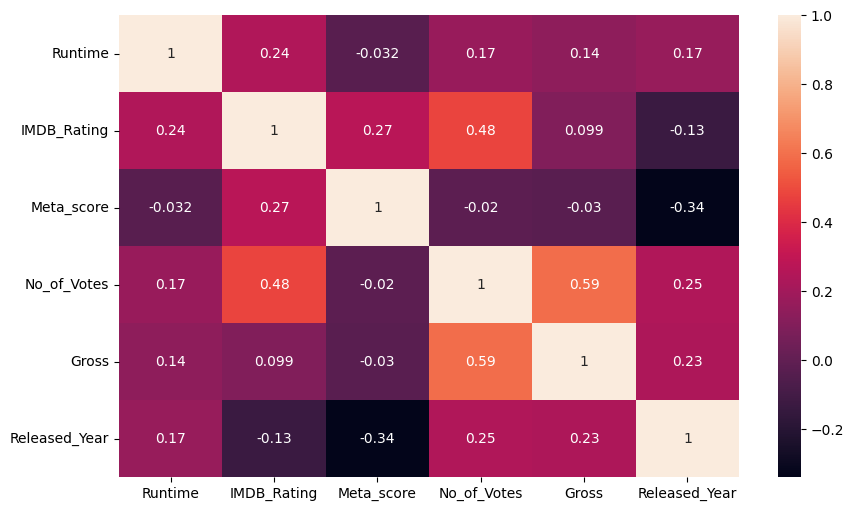

In [194]:
#Seleciona as variáveis numéricas que serão utilizadas
correlações = imdb[['Runtime','IMDB_Rating','Meta_score','No_of_Votes','Gross','Released_Year']]

#Executa as correlações
correlações = correlações.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlações, annot=True)

plt.show()

### 3.1.2 Correlações: análise de expectativa de faturamento

- <b>Faturamento x Número de votos: 0,59</b>
    - A maior correlação que explica o faturamento de um filme é o número de votos. Filmes mais votados faturam mais.
        - Uma hipótese para essa correlação é que filmes de mais sucesso geram mais engajamento e consequentemente mais votos.

- <b>Faturamento x Duração do Filme: 0,14</b>
    - Há uma fraca relação entre essas duas variáveis, indicando que filmes mais longos tem certa contribuição positiva na receita.

- <b>Faturamento e Ano de Lançamento: 0.23</b>
    - A segunda maior correlação para a expectativa de faturamento é a Faturamento e Ano de Lançamento. Vamos ver mais detalhadamente esse caso.

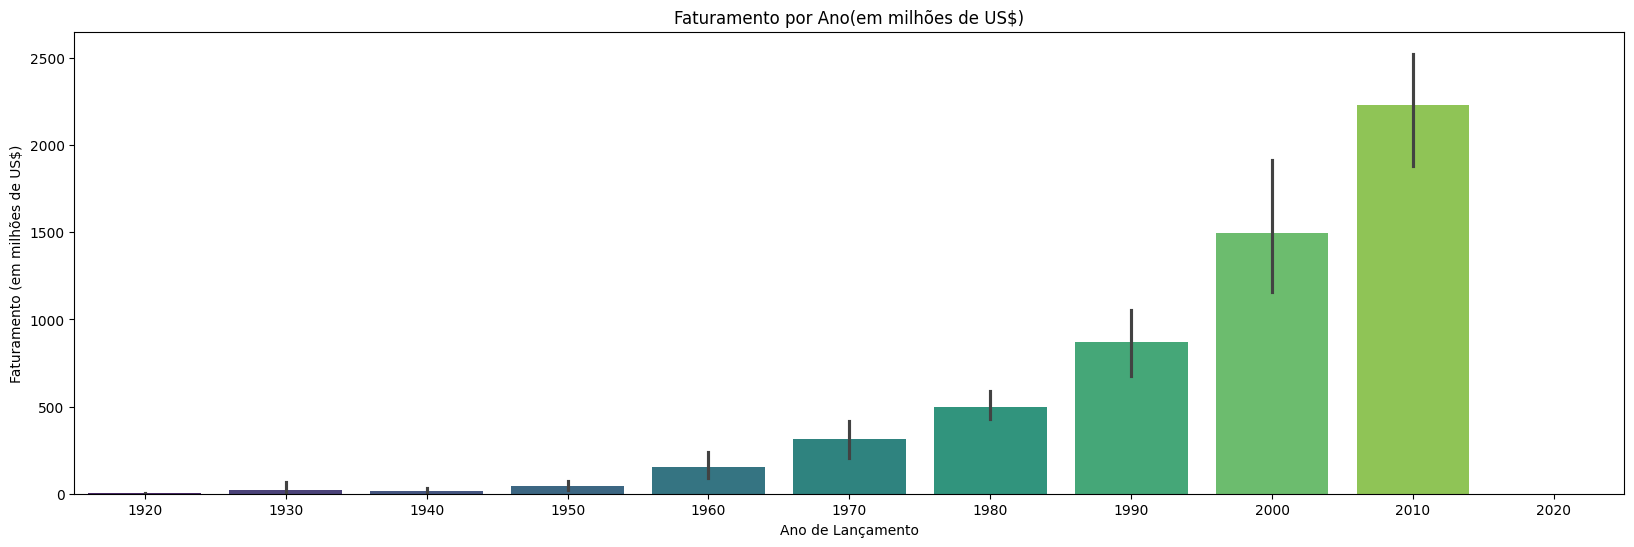

In [195]:
### 3.1.2 Correlações: Faturamento e Ano de Lançamento

#Copia os dados
faturamento = imdb[['Released_Year','Gross']].copy()

#Agrupa os dados
faturamento = faturamento.groupby(by=['Released_Year']).sum().sort_values(by=['Released_Year']).reset_index()

#Converte ano para década para facilitar a visualizaçção
faturamento['Released_Year'] = (faturamento['Released_Year'] // 10) *10

#Renomeia colunas
faturamento.columns = ['Ano de Lançamento','Faturamento (em milhões de US$)']

#Converte faturamento para milhões e arredonda
faturamento['Faturamento (em milhões de US$)'] = round((faturamento['Faturamento (em milhões de US$)'] / 1000000),2)

#Chama a função que faz o gráfico de barras
função_gráfico_barra(faturamento['Ano de Lançamento'],faturamento['Faturamento (em milhões de US$)'],'Faturamento por Ano(em milhões de US$)')

### 3.1.2 Correlações de Faturamento e Ano de Lançamento: análise

A correlação faz sentido uma vez que o faturamento dos filmes vem aumentado nas últimas décadas e conforme visto na etapa "2.2 - Lançamentos por ano" mais filmes também estão sendo lançados.

O faturamento zero para a década de 2020's possivelmente é explicado pelo fato do dataset ter sido gerado nesse mesmo ano, logo ele não tem os dados de 2020 em diante

## 3.3 - Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Para extrair insights precisamos ver quais são as palavras mais frequentes e para isso iremos utilizar a biblioteca WordCloud

Gênero: TODOS



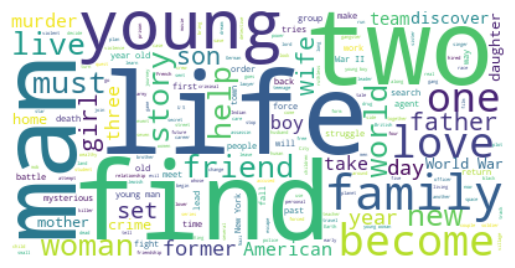

<Figure size 640x480 with 0 Axes>


As 10 palavras mais frequentes para todos os gêneros são:

  Palavra  Frequência
0    life         111
1    find         101
2     two          96
3     man          95
4   young          77
5  family          66
6  become          66
7    love          66
8     one          60
9  friend          57


Gênero: CRIME
As 10 palavras mais frequentes para o gênero Crime são:

  Palavra  Frequência
0     two          29
1   young          25
2     man          24
3  murder          24
4   crime          21
5     one          21
6  police          19
7    find          19
8  family          17
9  friend          15


Gênero: DRAMA
As 10 palavras mais frequentes para o gênero Drama são:

  Palavra  Frequência
0    life          96
1     man          76
2     two          73
3    find          73
4   young          57
5    love          52
6   story          50
7  family          47
8  become          45
9   woman          43


Gênero: ACTION
As 10 palavras mais frequentes para o gênero Action

In [196]:
#Palavras mais frequentes - TOTAL
overview = imdb['Overview'].copy()
overview_total = []
overview_total = " ".join(imdb['Overview'])

print("Gênero: TODOS\n")
geração_cloud_word(str(overview_total))

print()

print(f"As 10 palavras mais frequentes para todos os gêneros são:\n")
função_palavras_frequentes(overview_total)


#Palavras mais frequentes - GÊNERO

#Adquire os gêneros dos filmes
gêneros_individuais = imdb['Genre'].str.split(', ').copy()
gêneros_individuais  = gêneros_individuais.explode('Genre').reset_index(drop=True)
gêneros_individuais = gêneros_individuais.drop_duplicates()

#Itera sobre os gêneros
for gênero in gêneros_individuais:

    #Seleciona somente os overviews do gênero no for
    overview = imdb[imdb['Genre'].str.contains(gênero)]['Overview']

    #Concatena todos os overviews em uma única variável
    overview_concatenado = []
    overview_concatenado = " ".join(overview)

    
    #Exibe o Gênero
    print(f"\n\nGênero: {gênero.upper()}")

    #Gereação da Nuvem de Palavras
    #geração_cloud_word(overview_concatenado)


    print(f"As 10 palavras mais frequentes para o gênero {gênero} são:\n")
    função_palavras_frequentes(overview_concatenado)
    

### 3.3.3 - Insights -  Análise

Ao puxar as palavras mais comuns do "Overview" obter alguns insights.

É possível observar que e as palavras mais comuns de todos os filmes estão relacionados com temas da própria vivência humana, como vida, amor, família, amizade, entre outros. Essas palavras tem bastante correlação com o fato dos filmes dramáticos serem os mais populares, conforme pode ser observado na etapa 2.3.1.

Infelizmente não foi possivel estabelecer uma relação direta entre o "Oversight" e o gênero do filme. Em alguns casos as palavras mais frequentes estão diretamente relacionadas com o gênero, como por exemplos as palavras assassinato, detetive e policial no gênero Mistério. Ao mesmo tempo a palavra vida(life) aparece como uma das mais comuns em 12 categorias diferentes de filmes.

Apesar de prática a bibliteca WordCloud não foi capaz de extrair o gênero com base no Overview


# 4 - PREVISÃO DE NOTA

Para fazer a previsão de notas para o dataset do IMDB serão treinados alguns modelos de aprendizagem de máquina para se obter o qual deles apresenta o melhor desempenho.

<b>O problema a ser resolvido é uma REGRESSÃO</b>, pois se está prevendo uma variável contínua. As classificações são utilizadas quando a saída é uma variável categórica.

## 4.1 Pre-processamento

### 4.1.1  - Criar uma variável para copiar o dataset

In [197]:
#Copiar dados para o modelo

imdb_dados_modelo = imdb.copy().dropna()

imdb_dados_modelo.dropna(inplace=True)

Como é característico da indústria de cinema filmes que fogem a regra em termos de sucesso optou-se por não tratar os outliers. Acredito que essa opção seja mais adequada para retratar o setor.

Optou-se por eliminar os valores nulos para melhorar o desempenho dos algoritmos.

### 4.1.2 - Selecionar as variáveis

In [198]:
# Definir as variáveis dependentes e independentes
X = imdb_dados_modelo.drop(columns=['IMDB_Rating', 'Overview','Series_Title'])  # Variáveis independentes
y = imdb_dados_modelo['IMDB_Rating']  # Variável dependente

#Definir as variáveis que serão usadas
variáveis_numéricas = ['Released_Year', 'Meta_score', 'No_of_Votes','Gross','Runtime']
variáveis_categóricas = ['Genre','Director','Star1', 'Star2', 'Star3', 'Star4',]



### 4.1.3 - Preparar o pipeline

Foi utilizado o pipeline do Sklearn para poder encadear várias fases do pré-processamento em uma única etapa.

Para melhor ajustar os parâmetros dos modelos foi utilizado o **GridSearchCV**. O GridSearchCV vai fazer um grid com todas as combinações dos hiperparâmetros inseridos e irá testar cada um deles.

A vantagem do GridSearch a **otimização dos hiperparâmetros** de foram automática.
A desvantagem é o custo computacional e a limitação das combinações inseridas nos hiperparâmetros.

In [199]:
# Define como as colunas serão transformadas
transformador_numérico = Pipeline(steps=[
                                        ('scaler', StandardScaler())
])

transformador_categórico = Pipeline(steps=[
                                         ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))
])

# Com o ColumnTransformer será aplicado nas colunas do df as transformações anteriores
preprocessamento = ColumnTransformer(transformers=[
    ('numérico', transformador_numérico, variáveis_numéricas),
    ('categórico', transformador_categórico, variáveis_categóricas)
])

#Cria uma variável para receber o resultado dos modelos
resultados_modelos = []
pd.DataFrame(resultados_modelos)

""


#### 4.1.3 - Preparar o pipeline - Transformações

Como os algoritmos entendem somente valores numéricos foi utilizado o **OneHotEncoder** para transformar as variáveis categóricos em números.

Como as colunas numéricas possuem escalas muito diferentes de números (avalições de 8 pontos e faturamento de bilhões), é preciso trazer todos esses números para uma mesma escala. Para isso foi utilizado o **StandardScaler**.

## 4.2 - Testar modelos

Foram testados 6 algortimos diferentes de aprendizado de máquina.
Foi o escolhido o **MAE (Mean Absolute Error)** como medida de performance por ser uma medida menos sensível a outliers e de fácil compreensão.

### 4.2.1 - Linear Regressor

A **Regressão Linear** é um modelo simples e robusto para estabelecer a relação entre uma variável dependente e uma ou mais variáveis dependente.

**Vantagens:**
- Simplicidade
- Baixo custo computacional

**Desvantagens:**
- Sensibilidade a outliers
- Suposição de que há uma correlação linear

In [200]:
#Define o modelo
modelo_regressão = LinearRegression()

#Define os parâmetro
parâmetros = {
    }

#Chama a função
resultados_modelos = função_testa_modelo(modelo_regressão,parâmetros,resultados_modelos)
print("")

print(resultados_modelos)


Modelo testado: LinearRegression()

Melhores parâmetros encontrados:
{}

Melhor score de MAE encontrado:
-0.1959


[{'Modelo': LinearRegression(), 'Parâmetros': {}, 'MAE': -0.1959}]


### 4.2.2 - KNN (K-nearest Neighbors)

O é um algoritmo que pode ser utilizado tanto para classificação como regressão. Ela faz as previsões com base na proximidade/distância entre os dados.


**Vantagens:**
- Simplicidade
- Flexibilidade
- Não paramétrico (necessidade de poucos parâmetros)

**Desvantagens:**
- Custo computacional maior quando maior for o dataset
- Escolha do k(distância). Um k errado pode facilmente levar a um overtting ou underfitting
- Sensível a dimensionalidade

In [201]:
#Define o modelo
modelo_regressão = KNeighborsRegressor()

#Define os parâmetro
parâmetros = {
    'modelo__n_neighbors': [3, 5, 7, 9, 11],  # Número de vizinhos a serem considerados
    'modelo__weights': ['uniform', 'distance'],  # Pesos dos vizinhos (uniforme ou inverso da distância)
    'modelo__p': [1, 2],  # Métrica de distância (1 para Manhattan, 2 para Euclidiana)
    'modelo__algorithm': ['auto'],
    'modelo__n_jobs': [-1]
}


#Chama a função
resultados_modelos = função_testa_modelo(modelo_regressão,parâmetros,resultados_modelos)
print("")


Modelo testado: KNeighborsRegressor()

Melhores parâmetros encontrados:
{'modelo__algorithm': 'auto', 'modelo__n_jobs': -1, 'modelo__n_neighbors': 7, 'modelo__p': 2, 'modelo__weights': 'uniform'}

Melhor score de MAE encontrado:
-0.2263




### 4.2.3 - SVR (Support Vector Regression)

O SVR é baseada no SVM (Support Vector Machine)

**Vantagens:**
- Precisão
- Robustez a outliers
- Fexiblidade


**Desvantagens:**
- Custo computacional
- Escolha de hiperparâmetros

In [202]:
#Define o modelo
modelo_regressão = SVR(kernel='linear')

#Define os parâmetro
parâmetros = {
    'modelo__C': [0.1, 1, 10, 100],  # Parâmetro de regularização
    'modelo__epsilon': [0.1, 0.2, 0.5]  # Tolerância da função de perda
}

#Chama a função
resultados_modelos = função_testa_modelo(modelo_regressão,parâmetros,resultados_modelos)
print("")



Modelo testado: SVR(kernel='linear')

Melhores parâmetros encontrados:
{'modelo__C': 1, 'modelo__epsilon': 0.1}

Melhor score de MAE encontrado:
-0.207




### 4.2.4 - Random Forest Regressor

É um algoritmo que adota várias Decision Trees para uma regressão. Cada árvore de decisão no conjunto é treinada de forma independente com uma amostra aleatória do conjunto de dados e produz uma previsão

**Vantagens:**
- Alta precisão
- Robustez
- Bom para relações não lineares


**Desvantagens:**
- Alto custo computacional. De todos os algoritmos testado aqui ele foi o mais demorado
- Predições mais lentas
- Interpretação complexa

In [203]:
#Define o modelo
modelo_regressão = RandomForestRegressor()

#Define os parâmetro
parâmetros = {
    'modelo__n_estimators': [50, 100, 200],        # Número de árvores na floresta
    'modelo__max_depth': [None, 10, 15, 20],       # Profundidade máxima das árvores
    'modelo__min_samples_split': [2, 5, 10],       # Número mínimo de amostras necessárias para dividir um nó
    'modelo__min_samples_leaf': [1, 2, 3],         # Número mínimo de amostras necessárias para ser uma folha
    'modelo__n_jobs': [-1]
    }

#Chama a função
resultados_modelos = função_testa_modelo(modelo_regressão,parâmetros,resultados_modelos)
print("")

### 4.2.5 - GradientBoostingRegressor

É um algoritmo baseado em Decision Trees que gera novas árvores são criadas para corrigir as árvores anteriores.

**Vantagens:**
- Alta precisão
- Robustez a outliers
- Captura de relações complexas


**Desvantagens:**
- Custo computacional
- Sensível a overfitting
- Ajuste de hiperparâmetos

In [ ]:
#Define o modelo
modelo_regressão = GradientBoostingRegressor()

#Define os parâmetro
parâmetros = {
    'modelo__n_estimators': [50, 100, 200],  # Número de árvores no boosting
    'modelo__learning_rate': [0.01, 0.1, 0.5],  # Taxa de aprendizado
    'modelo__max_depth': [3, 5, 7]  # Profundidade máxima das árvores
}

#Chama a função
#resultados_modelos = função_testa_modelo(modelo_regressão,parâmetros,resultados_modelos)
print("")

### 4.2.6 - AdaBoostRegressor

É um algoritmo que combina várias versões de modelos de regressão mais simples.


**Vantagens:**
- Alta precisão
- Robustez a overfitting
- Flexibilidade

**Desvantagens:**
- Alto custo computacional
- Sensível a outliers
- Ajuste de hiperparâmetros

In [ ]:
#Define o modelo
modelo_regressão = AdaBoostRegressor()

#Define os parâmetro
parâmetros = {
    'modelo__n_estimators': [50, 75, 100, 150],
    'modelo__learning_rate': [0.1,0.2,0.3]
}

#Chama a função
#resultados_modelos = função_testa_modelo(modelo_regressão,parâmetros,resultados_modelos)
print("")

## 4.3 Seleciona o melhor modelo

In [ ]:
#Converte a lista 'resultados_modelos' para df
resultados_modelos = pd.DataFrame(resultados_modelos)

#Encontra o índice do melhor modelo
indice_melhor_modelo = resultados_modelos['MAE'].idxmax()

#Seleciona o melhor modelo
melhor_modelo = resultados_modelos.iloc[resultados_modelos['MAE'].idxmax()]

## 4.4 - Faz limpeza dos dados do filme a ser previsto

In [ ]:
#Aplicar as transformações feitas no EDA para o filme "The Shawshank Redemption"

filme = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}

filme = pd.DataFrame(filme, index=[1])

# Converte a coluna Meta_score para float
filme['Meta_score'] = filme['Meta_score'].astype(float)

# Converte a coluna No_of_Votes para float
filme['No_of_Votes'] = filme['No_of_Votes'].astype(float)

# Remove vírgulas da coluna Gross e converte para float
filme['Gross'] = filme['Gross'].str.replace(',', '')
filme['Gross'] = filme['Gross'].astype(float)

# Converte os valores nulos para np.nan na coluna Gross
filme['Gross'].replace('', np.nan, inplace=True)

# Insere o ano do filme ('PG')
filme['Released_Year'].replace('PG', 1995, inplace=True)

# Converte o ano para integral
filme['Released_Year'] = filme['Released_Year'].astype(int)

# Remove ' min' do texto da coluna Runtime e converte para inteiro
filme['Runtime'] = filme['Runtime'].str.replace(' min', '').astype(int)

## 4.5 - Faz o treino e a previsão

In [ ]:
# Definir o modelo a ser criado
modelo_regressão = melhor_modelo['Modelo']

#parâmetros = melhor_modelo['Parâmetros'].tolist()
#print(parâmetros)

# Criar a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessamento),
    ('modelo', modelo_regressão)
])

# Aplicar o GridSearch
grid_search = GridSearchCV(
    pipeline,  # Executa a pipeline com o preprocessamento e o modelo de regressão
    melhor_modelo['Parâmetros'],  # Carrega os parâmetros a serem testados pelo modelo
    cv=5,  # Faz um cross-validation 5 vezes
    scoring= 'neg_mean_absolute_error'
)

# Treinar o modelo
grid_search.fit(X, y)

nota_filme = grid_search.predict(filme)

print(f"A nota prevista do filme 'The Shawshank Redemption' é de {round(float(nota_filme),2)}")



## Pickle

### Gerar um pickle

In [ ]:
#Cria um arquivo chamado 'Modelo de Regressão.pkl' na mesma pasta em que está localizado esse .ipynt
pickle.dump(grid_search, open('modelo_regressão_imdb.pkl', 'wb'))

### Carregar um pickle

Caso deseje carregar o modelo já treinado utilize o código abaixo

In [ ]:
# Carregar o arquivo .pkl

with open("modelo_regressão_imdb.pkl", 'rb') as file:
    modelo_treinado = pickle.load(file)

## Requisitos

### Gerar os requisitos de para executar corretamente o código

In [ ]:
# Gerar o arquivo de requisitos
!pip freeze > requirements.txt

### Instalar os pacotes necessários para rodar o sistema.

Remova o "#" do códigoa abaixo para instalar todos os pacotes necessários para executar corretamente esse código.